<a href="https://colab.research.google.com/github/sanyakapoor27/UNETR-train/blob/main/UNETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from keras import backend as K

In [2]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [3]:
#downloading kaggle.json file
!gdown "https://drive.google.com/uc?id=1UvRuiTaifBWLHnueH8z4Bj5gihcaxmiM"

Downloading...
From: https://drive.google.com/uc?id=1UvRuiTaifBWLHnueH8z4Bj5gihcaxmiM
To: /content/kaggle.json
100% 70.0/70.0 [00:00<00:00, 273kB/s]


In [4]:
#making kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andrewmvd/breast-cancer-cell-segmentation

 99% 93.0M/93.7M [00:04<00:00, 28.2MB/s]
100% 93.7M/93.7M [00:04<00:00, 21.3MB/s]


In [7]:
!unzip /content/breast-cancer-cell-segmentation.zip

Archive:  /content/breast-cancer-cell-segmentation.zip
  inflating: Images/ytma10_010704_benign1_ccd.tif  
  inflating: Images/ytma10_010704_benign1_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign2_ccd.tif  
  inflating: Images/ytma10_010704_benign2_ccd.tif.xml  
  inflating: Images/ytma10_010704_benign3_ccd.tif  
  inflating: Images/ytma10_010704_benign3_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant1_ccd.tif  
  inflating: Images/ytma10_010704_malignant1_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant2_ccd.tif  
  inflating: Images/ytma10_010704_malignant2_ccd.tif.xml  
  inflating: Images/ytma10_010704_malignant3_ccd.tif  
  inflating: Images/ytma10_010704_malignant3_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign1_ccd.tif  
  inflating: Images/ytma12_010804_benign1_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign2_ccd.tif  
  inflating: Images/ytma12_010804_benign2_ccd.tif.xml  
  inflating: Images/ytma12_010804_benign3_ccd.tif  
  inflating

In [8]:
def preprocessing(dir_name, img_size):

  preprocessed_image = []

  for image in os.listdir(dir_name):
    if image.lower().endswith('.tif'):
      path = os.path.join(dir_name, image)

      image = imread(path)
      image = cv2.resize(image, img_size)
      image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      #image = image / 255.
      preprocessed_image.append(image)

  preprocessed_image = np.array(preprocessed_image)

  print("Preprocessing is complete!")
  return preprocessed_image

In [9]:
def preprocessing_clr(dir_name, img_size):

  preprocessed_image = []

  for image in os.listdir(dir_name):
    if image.lower().endswith('.tif'):
      path = os.path.join(dir_name, image)

      image = imread(path)
      image = cv2.resize(image, img_size)
      #image = image / 255.
      preprocessed_image.append(image)

  preprocessed_image = np.array(preprocessed_image)

  print("Preprocessing is complete!")
  return preprocessed_image

In [10]:
imagedir = "/content/Images"
maskdir = "/content/Masks"

In [11]:
images = preprocessing(imagedir, (256,256))
masks = preprocessing_clr(maskdir, (256,256))

Preprocessing is complete!
Preprocessing is complete!


In [12]:
masks.shape

(58, 256, 256)

In [13]:
images.shape

(58, 256, 256)

In [14]:
#splitting with ratio of 90:10 for train:test
x1, test_images, x2, test_masks = train_test_split(images, masks, test_size=0.1, random_state=42)

In [15]:
#further splitting for validation
train_images, x_nouse, train_masks, y_nouse = train_test_split(x1, x2, test_size=0.1, random_state=42)

Text(0.5, 1.0, 'Mask')

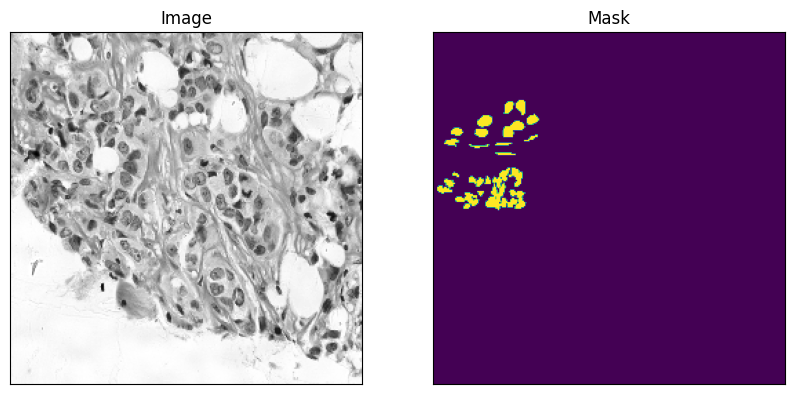

In [16]:
#displaying images with masks
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(images[1], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(masks[1])
plt.xticks([])
plt.yticks([])
plt.title("Mask")

In [17]:
def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

In [18]:
def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

In [19]:
def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

In [20]:
def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

In [21]:
def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape) ## (None, 256, 768)

    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = L.Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)

    return Model(inputs, outputs, name="UNETR_2D")

In [22]:
if __name__ == "__main__":
    config = {}
    config["image_size"] = 256
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 16
    config["num_channels"] = 1

    model = build_unetr_2d(config)
    model.summary()

Model: "UNETR_2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 256, 768)             197376    ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 768)             0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 256, 768)             1536      ['tf.__operators__.add[

In [23]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1) - intersection
    smooth = 1.0
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [24]:
def iou_loss(y_true, y_pred):
    return 1 - iou(y_true, y_pred)

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.metrics.binary_crossentropy, metrics=[iou])

In [ ]:
unetr_history = model.fit(train_images,
          train_masks,
          batch_size=4,
          epochs=2,
          verbose=1,
          validation_data=(test_images, test_masks))

In [45]:
test_img_number = random.randint(0, len(test_images))
test_img = test_images[test_img_number]
ground_truth=test_masks[test_img_number]
test_img_norm=test_img[:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

pred1 = model.predict(test_img_input)

preds=np.array(pred1)
prediction = np.argmax(preds, axis=3)

1/1 [==============================] - 7s 7s/step


In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img[:,:], cmap='gray')

plt.subplot(222)
plt.title('Prediction on test image')
plt.imshow(prediction[0], cmap='gray')
plt.show()